# Peak finder

Use 1d convolutions to create code to detect peaks and their size. Specifically detect half-maxima. Will practice conv-nets and residual connections

Package the final model into a docker container with and exposed port and a flask model

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import typing as tp

import h5py

import scipy.linalg as sp_la

import tensorflow.data as tfd
import tensorflow as tf
import tensorflow.keras as ks

import requests as rq
import json

2022-06-05 21:18:22.031217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-05 21:18:22.031286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate data

Generate mixtures of random peaks with noise, as well as the ground truth. Do this by composition, with noise added at the end. Start with symmetric peaks and proceed to add skew later on

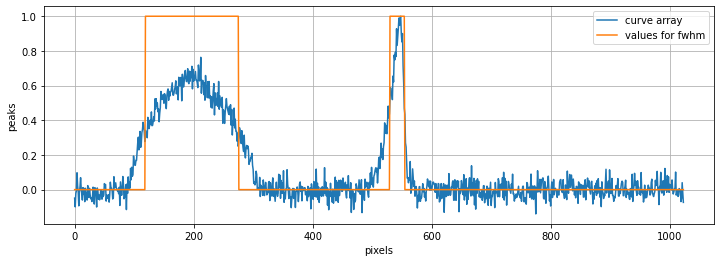

In [2]:
def random_peak_gen(
    peak_min_max_width_px: tp.Tuple[float, float]=(3.0, 8.0),
    peak_center_clearance_pw: float=1.3,
    px_count: int=256
)->np.ndarray:
    """
    Generate random peak, with background level at #zero and maximum at 1.0. The Generated peak is Gaussian
    
    Arguments:
    ----------
        peak_min_max_fwhm_px: (minimum, maximum) width of the peak in pixels
        peak_center_clearance_pw: distance from the centre of the peak to the edge of the window as a multiple of peak width
        px_count: number of pixels in the window
        
    Returns:
    --------
        numpy array of heights at different positions of the peak, i.e. the y=y(x) where x is the simple pixel indices
    """
    
    # get the width of the peak
    peak_width_px = npr.uniform(*peak_min_max_width_px)
    peak_center_clearance_px = peak_center_clearance_pw * peak_width_px
    
    # get the position of peak centre
    peak_center_pos_px = npr.uniform(low=peak_center_clearance_px, high=(px_count-1)-peak_center_clearance_px)
    
    # generate peak
    x = np.arange(px_count)
    scaled_x = (x-peak_center_pos_px)/peak_width_px
    y = np.exp(-scaled_x**2) 
    y /= np.max(y)
    
    return y
    
####

def apply_skew(
    val_arr: np.ndarray,
    skew_kernel_width_minmax: tp.Tuple[float, float]=(0.05, 0.3),
    skew_pow_mag_max: float=10.0
)->np.ndarray:
    """
    apply skew to the given trace by generating a skew kernel and then convolving with it. The shape
    of the kernel is initially an isoscelese triangle, i.e. 0->1->0, but then one half of the triangle
    is ranomly raised to some high power which makes the kernel asymmetric. Witdth of the kernel
    controlls how strongly it deforms the source array
    
    Arguments:
    ----------
        * val_arr: a numpy array with the source curve
        * skew_pow_mag_max: min max for the width of the kernel as a ratio of the width of the incoming val_arr
        * skew_pow_mag_max: boundary (magnitude) for the random power to which either the left
            or the right side of the kernel will be raised (depending on the sign of the random exponent)
            
    Returns:
    --------
        * skewed curve with the same number of pixels
    """
    
    # prepare padding dith
    padding_px = len(val_arr)
    
    # generate the key params to create the skewing kernel
    skew_half_px = np.floor(padding_px * npr.uniform(*skew_kernel_width_minmax)).astype(int)-1
    skew_pow = npr.uniform(low=-skew_pow_mag_max, high=skew_pow_mag_max)
    
    # create and pply the kernel
    if skew_pow>0:
        skew_kernel = np.concatenate([np.linspace(0, 1, skew_half_px), [1.0], np.linspace(1, 0, skew_half_px)**(skew_pow)])
    else:
        skew_kernel = np.concatenate([np.linspace(0, 1, skew_half_px)**(-skew_pow), [1.0], np.linspace(1, 0, skew_half_px)])
    
    # add padding to input. allows to avoid edge-effects when using kernels
    padded_arr = np.concatenate([np.zeros(padding_px), val_arr, np.zeros(padding_px)])
    
    # apply kernel and remove padding
    skew_padded_arr = np.convolve(padded_arr, skew_kernel, mode='same')
    skew_arr = skew_padded_arr[padding_px:(len(val_arr)+padding_px)]
    
    # renormalize
    skew_arr /= max(skew_padded_arr)
    
    return skew_arr

###
    
def apply_vertical_scaling(
    val_arr: np.ndarray,
    scaling_pow_minmax: tp.Tuple[float, float]=(0.5, 3)
)->np.ndarray:
    """
    Apply vertical scaling by raising the array to a random power
    
    Arguments:
    ----------
        val_arr: array of points for the curve
        scaling_pow_minmax: minimum and maximum of the power to which the array should be raised
        
    Returns:
    --------
        scaled numpy array
    """
    
    scaling_pow = npr.uniform(*scaling_pow_minmax)
    
    scaled_arr = val_arr**scaling_pow
    scaled_arr /= max(scaled_arr)
    
    return scaled_arr

###

def add_noise(
    val_arr: np.ndarray,
    corr_vec: tp.List[float]=0.08*np.array([1, 0.5, -0.25, 0.125, 0.0675])
)->np.ndarray:
    """
    Apply noise by generating a noise vector and then mixing it using Toeplitz matrix with diagonals as in corr_vec
    
    Arguments:
    ----------
        val_arr: input array with signal
        corr_vec: vector for the mixing matrix, for noise. If corr_vec=[A, b, c]. then the matrix will be
            [A, b, c, 0, 0, 0, 0...0]
            [b, A, b, c, 0, 0, 0...0]
            [c, B, A, b, c, 0, 0...0]
            [0, c, b, A, b, c, 0...0]
            ....
            
            to match val_arr
            
    Returns:
    --------
        Input signal with added noise, and normalized
    """
    
    # generate correlated noise
    noise_vec = 2*npr.uniform(size=len(val_arr))-1
    corr_mat = sp_la.toeplitz([*corr_vec, *([0]*(len(val_arr)-len(corr_vec)))] )
    noise_vec = corr_mat @ noise_vec
    
    val_arr = val_arr + noise_vec
    
    return val_arr/max(val_arr)

###

def gen_random_multi_peak(
    peak_count_minmax: tp.Tuple[int, int]=(1, 5),
    mix_amp_minmax: tp.Tuple[float, float]=(0.1, 1.0),
    peak_min_max_width_px: tp.Tuple[float, float]=(3.0, 8.0),
    peak_center_clearance_pw: float=1.3,
    px_count: int=256,
    skew_kernel_width_minmax: tp.Tuple[float, float]=(0.05, 0.3),
    skew_pow_mag_max: float=10.0,
    scaling_pow_minmax: tp.Tuple[float, float]=(0.5, 3),
    corr_vec: tp.List[float]=0.08*np.array([1, 0.5, 0.25, 0.125, 0.0675]),
)->tp.Tuple[np.ndarray, np.ndarray]:
    """
    Putting it all together. Generate several peaks, mix them with different amplitudes then add noise
    
    Arguments:
    ---------
        peak_count_minmax: minimum and maximum for the random number of peaks
        mix_amp_minmax: minimum and maximum for the random amplitudes for mixing the different peaks
    
        (*see random_peak_gen*)
        peak_min_max_fwhm_px: (minimum, maximum) width of the peak in pixels
        peak_center_clearance_pw: distance from the centre of the peak to the edge of the window as a multiple of peak width
        px_count: number of pixels in the window
        
        (*see apply_skew*)
        skew_kernel_width_minmax: min max for the width of the kernel as a ratio of the width of the incoming val_arr
        skew_pow_mag_max: boundary (magnitude) for the random power to which either the left or the right side of the kernel 
            will be raised (depending on the sign of the random exponent)
            
        (*see apply_vertical_scaling*)
        scaling_pow_minmax: minimum and maximum of the power to which the array should be raised
        
        corr_vec: see add_noise
    
    Returns:
    -------
        signal array with peaks
        array with ones and zeros showing where different peaks were above Half-maximum (before mixing)
    """

    # number of peaks
    peak_count = npr.randint(*peak_count_minmax)
    
    val_arr = np.zeros(px_count)
    fwhm_arr = np.zeros(px_count)
    
    for i_peak in range(peak_count):
        cur_arr = random_peak_gen(
            peak_min_max_width_px=peak_min_max_width_px,
            peak_center_clearance_pw=peak_center_clearance_pw,
            px_count=px_count
        )
        #
        cur_arr = apply_skew(
            cur_arr,
            skew_kernel_width_minmax=skew_kernel_width_minmax,
            skew_pow_mag_max=skew_pow_mag_max
        )
        #
        cur_arr = apply_vertical_scaling(
            cur_arr,
            scaling_pow_minmax
        )
        
        # add peak
        val_arr += cur_arr * npr.uniform(*mix_amp_minmax)
        # set the logic
        fwhm_arr[cur_arr>=0.5] = 1.0
        
        
    if corr_vec is not None:
        val_arr = add_noise(
            val_arr,
            corr_vec=corr_vec
        )
        
    val_arr /= max(val_arr)
        
    return val_arr, fwhm_arr
    

###########

peak_arr, fwhm_arr = gen_random_multi_peak(
    px_count=1024,
    skew_kernel_width_minmax=(0.02, 0.2),
    corr_vec=0.04*np.array([1.0, 0.8, -0.6, 0.5, -0.25, 0.125, 0.075])
)

fig, ax = pp.subplots(figsize=(12, 4))

ax.plot(peak_arr, label='curve array')
ax.plot(fwhm_arr, label='values for fwhm')
ax.grid()
ax.set_xlabel('pixels')
ax.set_ylabel('peaks')
ax.legend()

### Store data

As part of pratice store the generated data into HDF5 file, to be loaded later.

In [ ]:
record_count = 40000
px_count = 1024
dset_save_path = '__peak_dump.h5py'

val_tens = np.zeros([record_count, px_count], dtype=float)
ground_tens = np.zeros([record_count, px_count], dtype=float)

###
for i_rec in range(record_count):
    peak_arr, fwhm_arr = gen_random_multi_peak(
        px_count=px_count,
        skew_kernel_width_minmax=(0.02, 0.2),
        corr_vec=0.04*np.array([1.0, 0.8, -0.6, 0.5, -0.25, 0.125, 0.075])
    )
    
    val_tens[i_rec, :] = peak_arr
    ground_tens[i_rec, :] = fwhm_arr
    
###

with h5py.File(dset_save_path, 'w') as fh:
    _ = fh.create_dataset('val_tens', data=val_tens, dtype='float')
    _ = fh.create_dataset('ground_tens', data=ground_tens, dtype='float')

## Load data into dataset

Load data into TF dataset - ready for model training.

2022-05-29 00:04:17.279287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-29 00:04:17.279320: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-29 00:04:17.279344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2022-05-29 00:04:17.280475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Examples of loaded data:


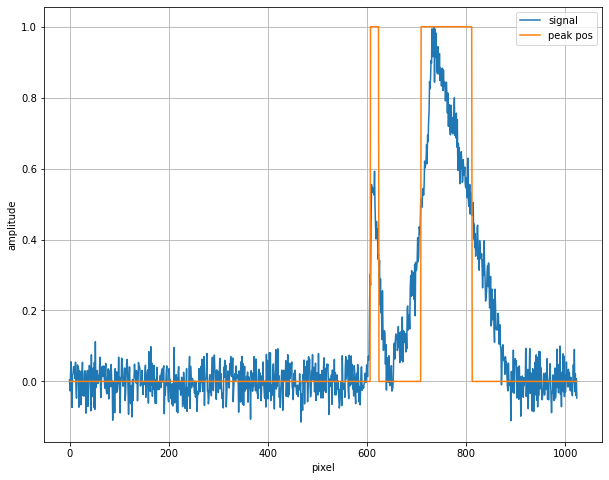

In [3]:
px_count = 1024

# generator to load data efficiently
def load_h5_data():
    dset_save_path = 'peak_dump.h5py'

    with h5py.File(dset_save_path, 'r') as fh:
        val_dset = fh['val_tens']
        ground_dset = fh['ground_tens']

        for vt, gt in zip(val_dset, ground_dset):
            yield (vt, gt)
####
    
dset = tfd.Dataset.from_generator(
    load_h5_data,
     output_signature=(
         tf.TensorSpec(shape=(px_count,), dtype=tf.float32),
         tf.TensorSpec(shape=(px_count,), dtype=tf.float32)
     )
)

few_rec_list = list(dset.shuffle(buffer_size=10).take(2))

print('Examples of loaded data:')

fig, ax = pp.subplots(figsize=(10, 8))
ax.plot(few_rec_list[0][0], label='signal')
ax.plot(few_rec_list[0][1], label='peak pos')
ax.set_xlabel('pixel')
ax.set_ylabel('amplitude')
ax.legend()
ax.grid()

### Train, Test, Validate split

In [4]:
test_size = 4000
test_dset = dset.take(test_size)
red_dset = dset.skip(test_size)

valid_size = 4000
valid_dset = red_dset.take(valid_size)
train_dset = red_dset.skip(valid_size)

## Configure model and train

Adding residual connections to make sure gradients from all parameters prpagate through

In [13]:
ker_size = 3
stride_size = 2
padding = 'same'

#########

input = ks.Input(
    shape = (px_count,),
    dtype=tf.float32
)

# residual connections
res_layer_1 = ks.layers.Conv1D(filters=1, kernel_size=3, strides=1, input_shape=(px_count,1),padding=padding)(tf.expand_dims(input, 2))
res_layer_1a = ks.layers.Conv1D(filters=12, kernel_size=3, strides=2**2, input_shape=(px_count,1),padding=padding)(tf.expand_dims(input, 2))

# reduce
# one channel px_count vector and batch
x = ks.layers.Conv1D(filters=3, kernel_size=ker_size, strides=1, input_shape=(px_count,1), activation='relu', padding=padding)(tf.expand_dims(input, 2))
x = ks.layers.Conv1D(filters=6, kernel_size=ker_size, strides=stride_size, activation='relu',padding=padding)(x)
x = ks.layers.Conv1D(filters=12, kernel_size=ker_size, strides=stride_size, activation='relu',padding=padding)(x)

# residual connections
res_layer_2 = ks.layers.Conv1DTranspose(filters=1, kernel_size=3, strides=2**2, input_shape=(px_count,1),padding=padding)(x)
res_layer_2a = ks.layers.Conv1D(filters=30, kernel_size=3, strides=1, input_shape=(px_count,1),padding=padding)(x)
x = ks.layers.Add()([x, res_layer_1a])

# internal layers fixed
x = ks.layers.Conv1D(filters=30, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)
x = ks.layers.Conv1D(filters=40, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)
x = ks.layers.Conv1D(filters=40, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)
x = ks.layers.Conv1D(filters=30, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)

# residual connections
res_layer_3 = ks.layers.Conv1DTranspose(filters=1, kernel_size=3, strides=2**2, input_shape=(px_count,1),padding=padding)(x)
x = ks.layers.Add()([x, res_layer_2a])

# increase
x = ks.layers.Conv1DTranspose(filters=12, kernel_size=ker_size, strides=stride_size, activation='relu',padding=padding)(x)
x = ks.layers.Conv1DTranspose(filters=6, kernel_size=ker_size, strides=stride_size, activation='relu',padding=padding)(x)
x = ks.layers.Conv1DTranspose(filters=3, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)
x = ks.layers.Conv1DTranspose(filters=1, kernel_size=ker_size, strides=1, activation='relu',padding=padding)(x)

# add second residual
x = ks.layers.Add()([x, res_layer_1, res_layer_2, res_layer_3])

output = ks.layers.Activation(activation='sigmoid')(tf.reshape(x, shape=(-1, x.shape[1])))

model = ks.Model(inputs=input, outputs=output)
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 1024, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1024, 3)      12          ['tf.expand_dims_2[0][0]']       
                                                                                                  
 conv1d_3 (Conv1D)              (None, 512, 6)       60          ['conv1d_2[0][0]']               
                                                                                              

In [70]:
# binary corss-entripy chould be good for matching probability distibutions
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['categorical_accuracy']
)

In [5]:
checkpoint_path = 'convnet_peakfinder'

In [71]:


callback_list = [
    ks.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss'
    )
]

# assumed dataset is that each record is a pair with train input and expected model output
history = model.fit(
    train_dset.batch(100),
    epochs=30,
    validation_data=valid_dset.batch(valid_size),
    callbacks=callback_list
)

Epoch 1/30
    320/Unknown - 29s 80ms/step - loss: 0.2209 - categorical_accuracy: 0.0000e+00INFO:tensorflow:Assets written to: convnet_peakfinder/assets
320/320 [==============================] - 34s 94ms/step - loss: 0.2209 - categorical_accuracy: 0.0000e+00 - val_loss: 0.1665 - val_categorical_accuracy: 0.0000e+00
Epoch 2/30
320/320 [==============================] - 34s 99ms/step - loss: 0.1412 - categorical_accuracy: 0.0000e+00 - val_loss: 0.1343 - val_categorical_accuracy: 0.0000e+00
Epoch 3/30
320/320 [==============================] - 34s 99ms/step - loss: 0.1084 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0989 - val_categorical_accuracy: 0.0000e+00
Epoch 4/30
320/320 [==============================] - 35s 101ms/step - loss: 0.0922 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0857 - val_categorical_accuracy: 0.0000e+00
Epoch 5/30
320/320 [==============================] - 34s 99ms/step - loss: 0.0837 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0824 - val_categorica

(0.0, 0.5)

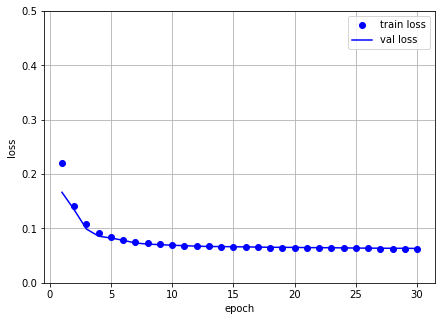

In [72]:
loss_arr = history.history['loss']
val_loss_arr = history.history['val_loss']

epoch_arr = np.arange(1, len(loss_arr)+1)

fig, ax = pp.subplots(figsize=(7, 5))
#
ax.plot(epoch_arr, loss_arr, 'bo', label='train loss')
ax.plot(epoch_arr, val_loss_arr, 'b', label='val loss')
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.set_ylim([0, 0.5])

Now the loss on test set

In [73]:
test_acc, _ = model.evaluate(test_dset.batch(test_size))

1/1 [==============================] - 2s 2s/step - loss: 0.0632 - categorical_accuracy: 0.0000e+00


Lets have a simple test of the model

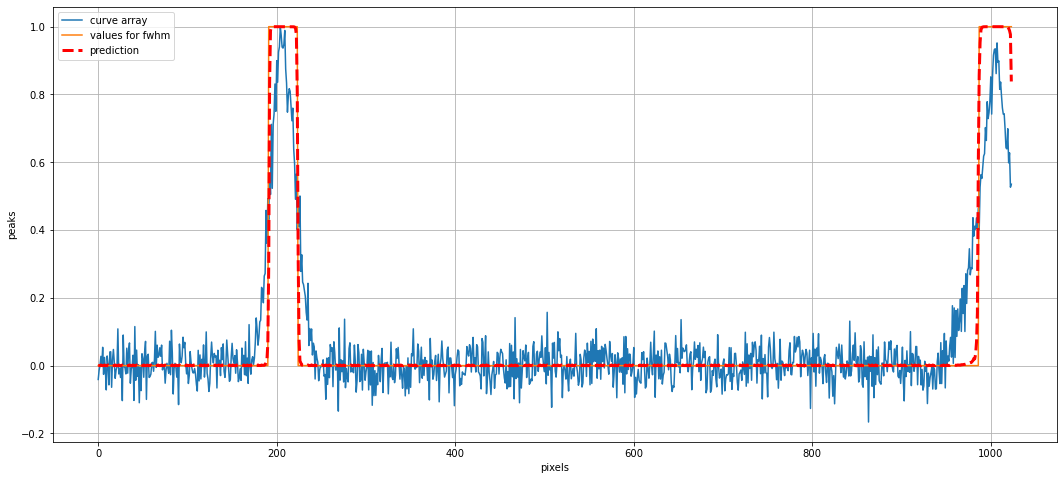

In [85]:
peak_arr, fwhm_arr = gen_random_multi_peak(
    px_count=1024,
    skew_kernel_width_minmax=(0.02, 0.2),
    corr_vec=0.04*np.array([1.0, 0.8, -0.6, 0.5, -0.25, 0.125, 0.075])
)

pred_arr = np.reshape(model(peak_arr[None,:,None]).numpy(), newshape=(-1,))

fig, ax = pp.subplots(figsize=(18, 8))

ax.plot(peak_arr, label='curve array')
ax.plot(fwhm_arr, label='values for fwhm')
ax.plot(pred_arr, label='prediction', c='r', linewidth=3, linestyle='--')
ax.grid()

ax.set_xlabel('pixels')
ax.set_ylabel('peaks')
ax.legend()


### Save model as bare-bones

In [59]:
chkpt_model = ks.models.load_model(checkpoint_path)
model_save_path = 'peakfinder_final_model'

class CustomModule(tf.Module):
    def __init__(self, keras_model):
        super(CustomModule, self).__init__()
        self.keras_model = keras_model

    @tf.function(input_signature=[tf.TensorSpec([None, px_count, 1], dtype=tf.float32)])
    def __call__(self, x):

        return self.keras_model(x)

    
module = CustomModule(chkpt_model)
tf.saved_model.save(module, model_save_path)


INFO:tensorflow:Assets written to: peakfinder_final_model/assets


## Load (checkpoint) and test sensitivity of output to input

Using optimizer, create input that leads to certain output and then differentiate to explore dependence

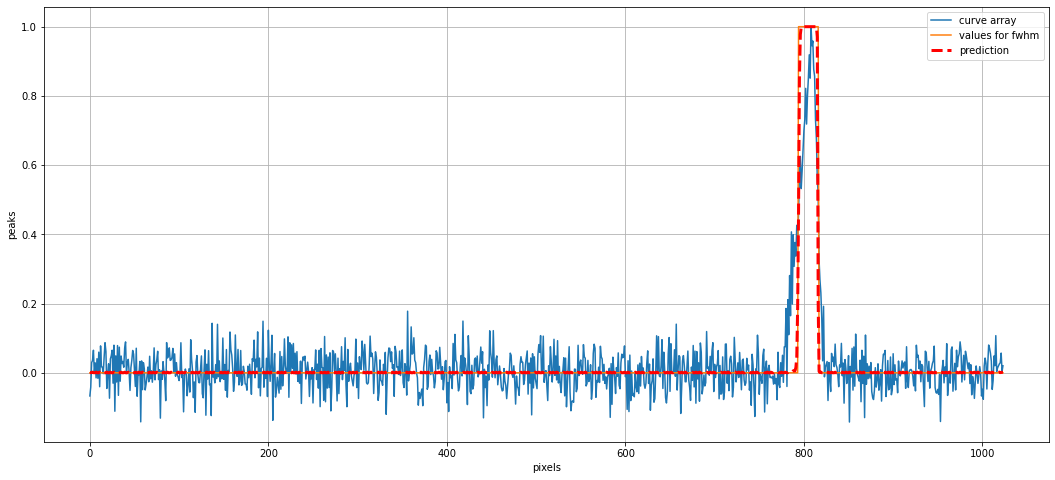

In [61]:
loaded_model = tf.saved_model.load(model_save_path)

peak_arr, fwhm_arr = gen_random_multi_peak(
    px_count=1024,
    skew_kernel_width_minmax=(0.02, 0.2),
    corr_vec=0.04*np.array([1.0, 0.8, -0.6, 0.5, -0.25, 0.125, 0.075])
)

pred_arr = np.reshape(loaded_model(peak_arr[None,:,None]).numpy(), newshape=(-1,))

fig, ax = pp.subplots(figsize=(18, 8))

ax.plot(peak_arr, label='curve array')
ax.plot(fwhm_arr, label='values for fwhm')
ax.plot(pred_arr, label='prediction', c='r', linewidth=3, linestyle='--')
ax.grid()

ax.set_xlabel('pixels')
ax.set_ylabel('peaks')
ax.legend()

Try finding input that leads to desired output. Create a trial input as a TF variable and a loss that puts the input into the model, get the output, and does cross-entropy based comparison

In [209]:
input_spec = loaded_model.__call__._function_spec._input_signature[0]

trial_input = npr.rand(input_spec.shape[1])
trial_input_tf = tf.Variable(trial_input[None, :, None], dtype=input_spec.dtype)

target_output = np.zeros(input_spec.shape[1])
i_set = int(len(target_output) * 0.75)
target_output[i_set:(i_set+50)] = 1
target_output_tf = tf.constant(target_output[None,:,None], dtype=tf.float32)

####

@tf.function
def output_loss():
    pred_tf = loaded_model(trial_input_tf)
    
    ol = \
        tf.keras.losses.BinaryCrossentropy()(target_output_tf, pred_tf) +\
        tf.reduce_mean(pred_tf**2)*0.01
    
    return ol

###

output_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=7.7064085>

Given loss, configure an optimization loop to optimize input in such a way as to get the desired output. Include some guard-rails. Without it the input we get is very noisy, and does not look like a real peak. This really signals the possible failure modes of the NN model. Good way to explore such modes, for the future

In [214]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)

step_count = 2400
wnd_width=5

for i_step in range(step_count):
    
    if i_step==0 or (i_step+1)==step_count or ((i_step+1)%300)==0:
        cur_loss = output_loss()
        print(f'({i_step})/({step_count}): loss={cur_loss.numpy():.3e}')

    # tends to go off the rails without this
    cur_trial = np.squeeze(trial_input_tf.numpy())
    cur_trial += (2*npr.rand(len(cur_trial))-1)*0.005
    cur_trial = np.convolve(cur_trial, np.ones(wnd_width), 'same')/wnd_width
    cur_trial /= np.max(np.abs(cur_trial))
    cur_trial = (np.abs(cur_trial) + cur_trial)/2
    
    trial_input_tf.assign(cur_trial[None,:,None])    
    
    opt.minimize(output_loss, [trial_input_tf])
    
    
    
####


(0)/(2400): loss=1.173e-03
(299)/(2400): loss=1.368e-03
(599)/(2400): loss=1.355e-03
(899)/(2400): loss=1.340e-03
(1199)/(2400): loss=1.343e-03
(1499)/(2400): loss=1.341e-03
(1799)/(2400): loss=1.352e-03
(2099)/(2400): loss=1.338e-03
(2399)/(2400): loss=1.345e-03


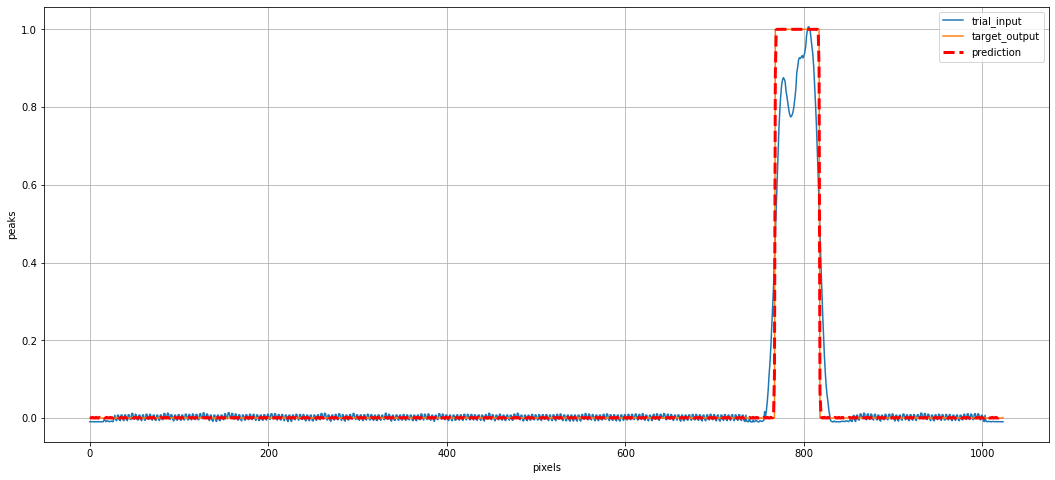

In [215]:
pred_output = np.squeeze(loaded_model(trial_input_tf).numpy())
optimized_input = np.squeeze(trial_input_tf.numpy())

fig, ax = pp.subplots(figsize=(18, 8))

ax.plot(optimized_input, label='trial_input')
ax.plot(target_output, label='target_output')
ax.plot(pred_output, label='prediction', c='r', linewidth=3, linestyle='--')
ax.grid()

ax.set_xlabel('pixels')
ax.set_ylabel('peaks')
ax.legend()

## Containerizing the model

Next step is to load the model into a docker and configure it for serving

Dockerfile

```
FROM tensorflow/tensorflow:latest

ARG WD=/payload
WORKDIR ${WD}/
COPY peakfinder_final_model ${WD}/peakfinder_final_model

COPY requirements.txt ${WD}/requirements.txt
RUN pip install -r requirements.txt

COPY app.py ${WD}/app.py

CMD ["python", "app.py", "--port=5000"]
```

Build with 
```
docker build -t peak_finder .
```

run with 
```
docker run -it -d --network=host  peak_finder:latest
```

Once docker is up and running, can get inference via request

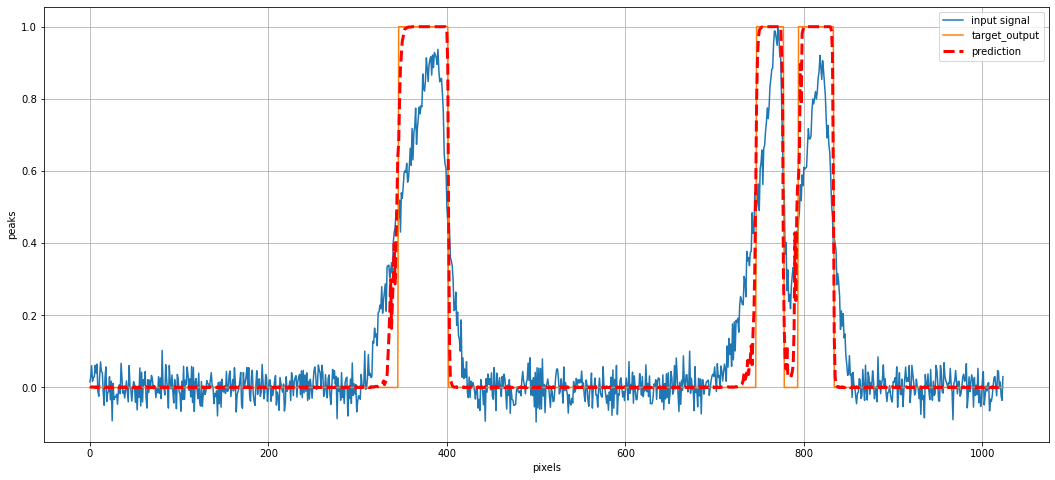

In [29]:
peak_arr, fwhm_arr = gen_random_multi_peak(
    px_count=1024,
    skew_kernel_width_minmax=(0.02, 0.2),
    corr_vec=0.03*np.array([1.0, 0.8, -0.6, 0.5, -0.25, 0.125, 0.075])
)

peak_str = '[' + ','.join([f'{val:.3f}' for val in peak_arr])+']'

try:
    res=rq.get(f'http://127.0.0.1:5000/findpeak/{peak_str}')

    
    if res.status_code==200:
        pred_arr = np.array(json.loads(res._content.decode('utf')))

        fig, ax = pp.subplots(figsize=(18, 8))

        ax.plot(peak_arr, label='input signal')
        ax.plot(fwhm_arr, label='target_output')
        ax.plot(pred_arr, label='prediction', c='r', linewidth=3, linestyle='--')
        ax.grid()

        ax.set_xlabel('pixels')
        ax.set_ylabel('peaks')
        ax.legend()

    else:
        print('Request failed')
    
except Exception:
    print('Failed')